# Compare snow cover products

In [4]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
# sys.path.insert(1, '/home/lalandmi/Dropbox/Thèse/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [1]:
# For parallelisation
from dask.distributed import Client
# client = Client(n_workers=32, threads_per_worker=1, memory_limit='6GB')
client = Client(n_workers=64, threads_per_worker=1, memory_limit='4GB')
# client = Client()
client

<Client: 'tcp://127.0.0.1:42564' processes=64 threads=64, memory=256.00 GB>

In [42]:
client.close()

## Set variables

In [5]:
period = slice('2001','2012')
latlim, lonlim = u.get_domain_HMA()
seasons = ['Annual', 'DJFMA', 'JJAS']
# root_data_path = '/home/lalandmi/Dropbox/data/' # local
root_data_path = '/data/mlalande/' # CICLAD

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

## Load topo

In [13]:
ds = xr.open_dataset(root_data_path+'GMTED2010/GMTED2010_15n120_0500deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

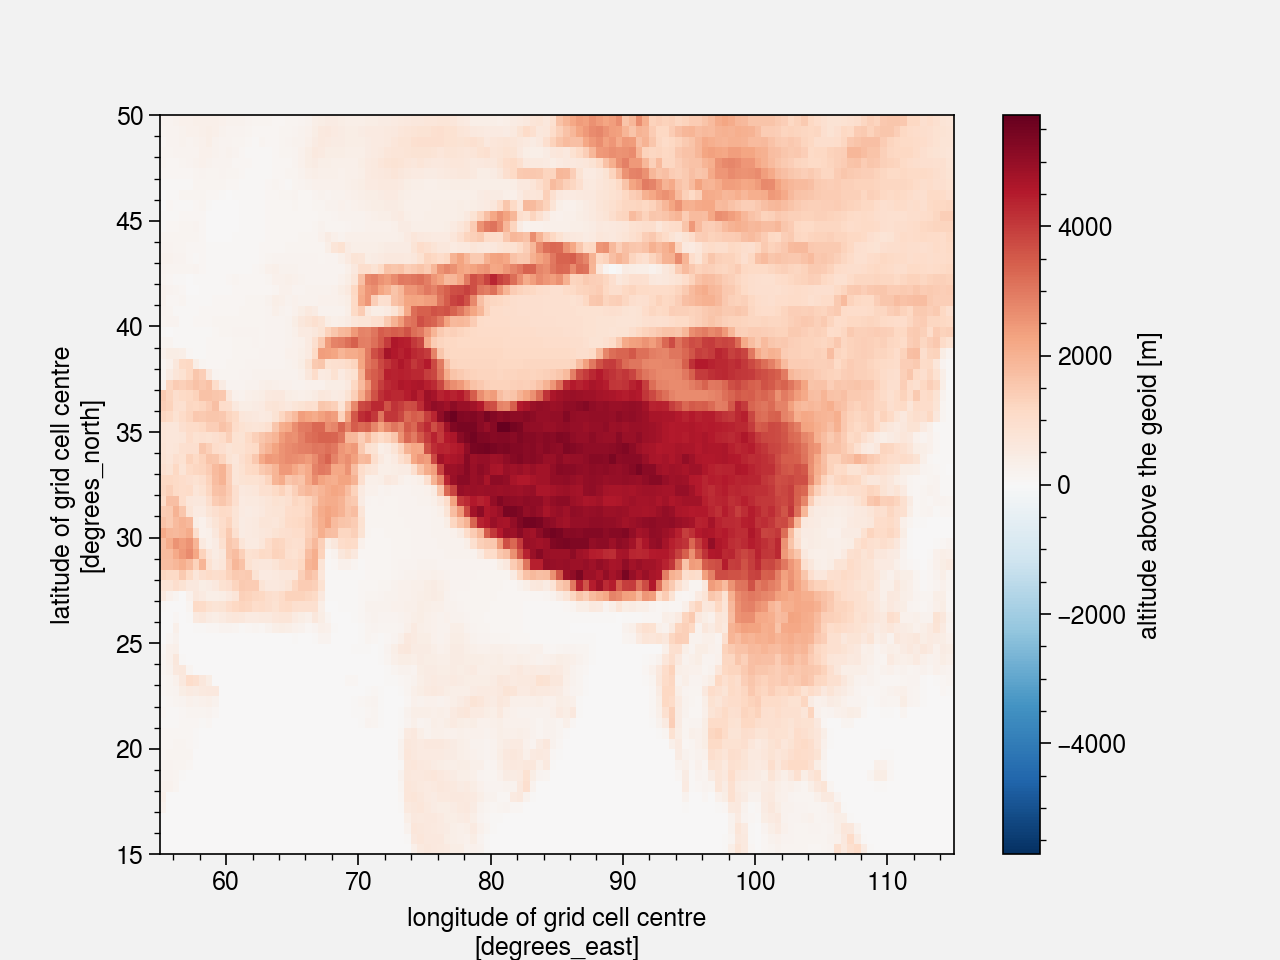

In [14]:
elevation.plot()

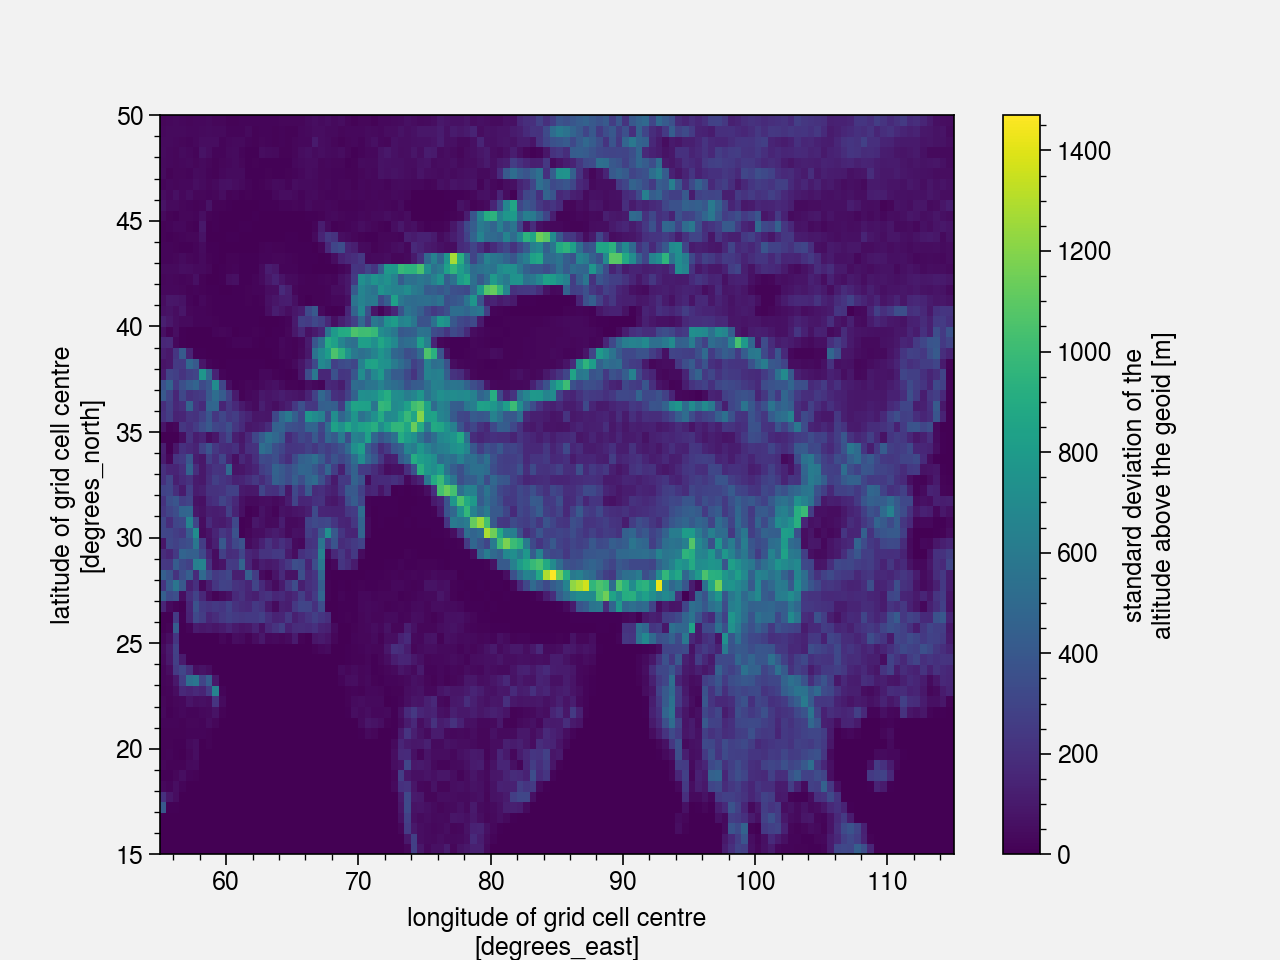

In [15]:
elevation_std.plot()

## NOAA CDR

In [16]:
ds_rutger = xr.open_dataset(root_data_path+'NOAA_CDR_NH_SCE/nhsce_v01r01_19661004_20201005.nc').sel(time=period)
with xr.set_options(keep_attrs=True): # Get the snc variable, keep only land data and convert to %
    obs = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100   
obs.attrs['units'] = '%'
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'}) # Rename lon and lat for the regrid

# Resamble data per month (from per week)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

# Because obs are not global (https://github.com/JiaweiZhuang/xESMF/issues/15)
import scipy
def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
noaa_cdr = regridder(obs)

/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Create weight file: bilinear_88x88_70x120.nc


/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


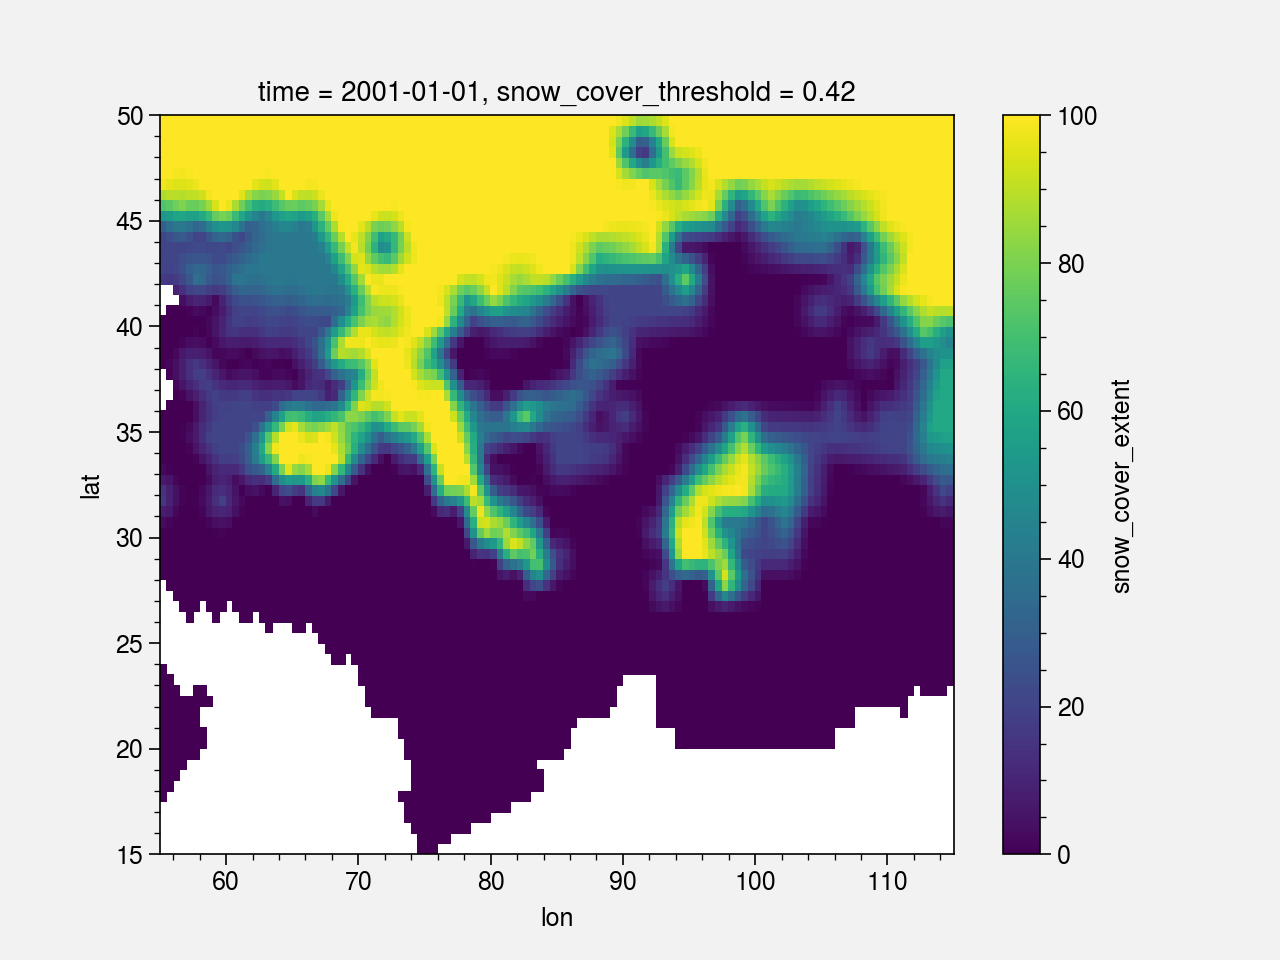

In [17]:
noaa_cdr[0].plot()

## NOAA CDR HR
I select only values with valid lat and lon for regrid: .isel(x=slice(158,867), y=slice(158,867)) (missing lat/lon values are set to ~9.9e+36)

In [18]:
ds_rutger = xr.open_dataset(root_data_path+'NOAA_CDR_NH_SCE/G10035-rutgers-nh-24km-weekly-sce-v01r00-19800826-20200831_newer_without_xy.nc').sel(time=period).isel(x=slice(158,867), y=slice(158,867))
with xr.set_options(keep_attrs=True): # Get the snc variable, keep only land data and convert to %
    obs = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100   
obs.attrs['units'] = '%'
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'}) # Rename lon and lat for the regrid

# Resamble data per month (from per week)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

# Because obs are not global (https://github.com/JiaweiZhuang/xESMF/issues/15)
import scipy
def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
noaa_cdr_hr = regridder(obs)

/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Create weight file: bilinear_709x709_70x120.nc


/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


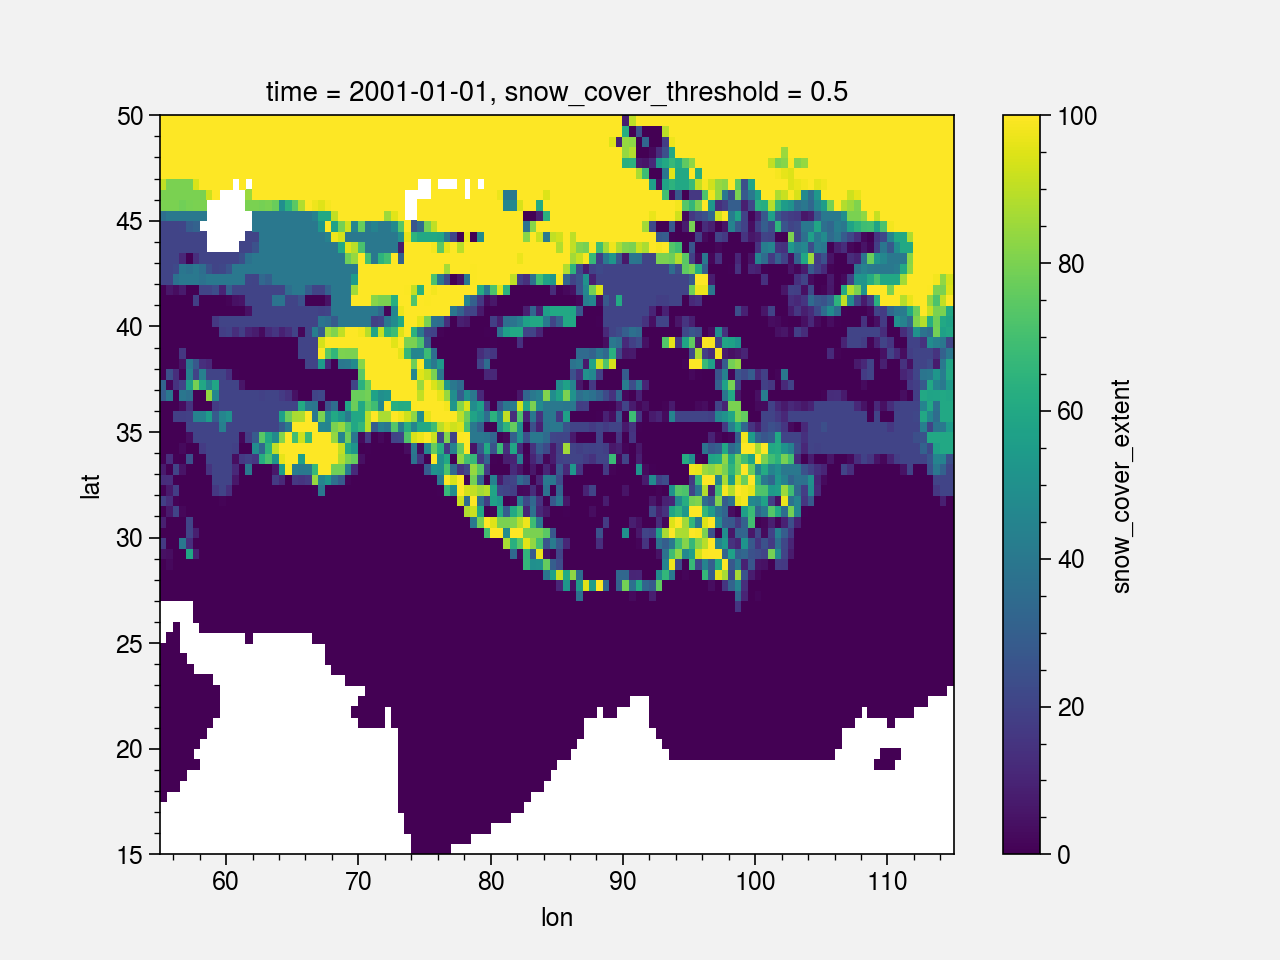

In [19]:
noaa_cdr_hr[0].plot()

## MEaSUREs
https://nsidc.org/data/nsidc-0530

In [20]:
obs = xr.open_mfdataset(
    root_data_path+'MEaSUREs/monthly/nhtsd25e2_*_v01r01.nc', combine='by_coords'
).merged_snow_cover_extent.sel(time=period).load() * 100
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'})

In [21]:
# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

# Because obs are not global (https://github.com/JiaweiZhuang/xESMF/issues/15)
import scipy
def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
measures = regridder(obs)

Create weight file: bilinear_720x720_70x120.nc


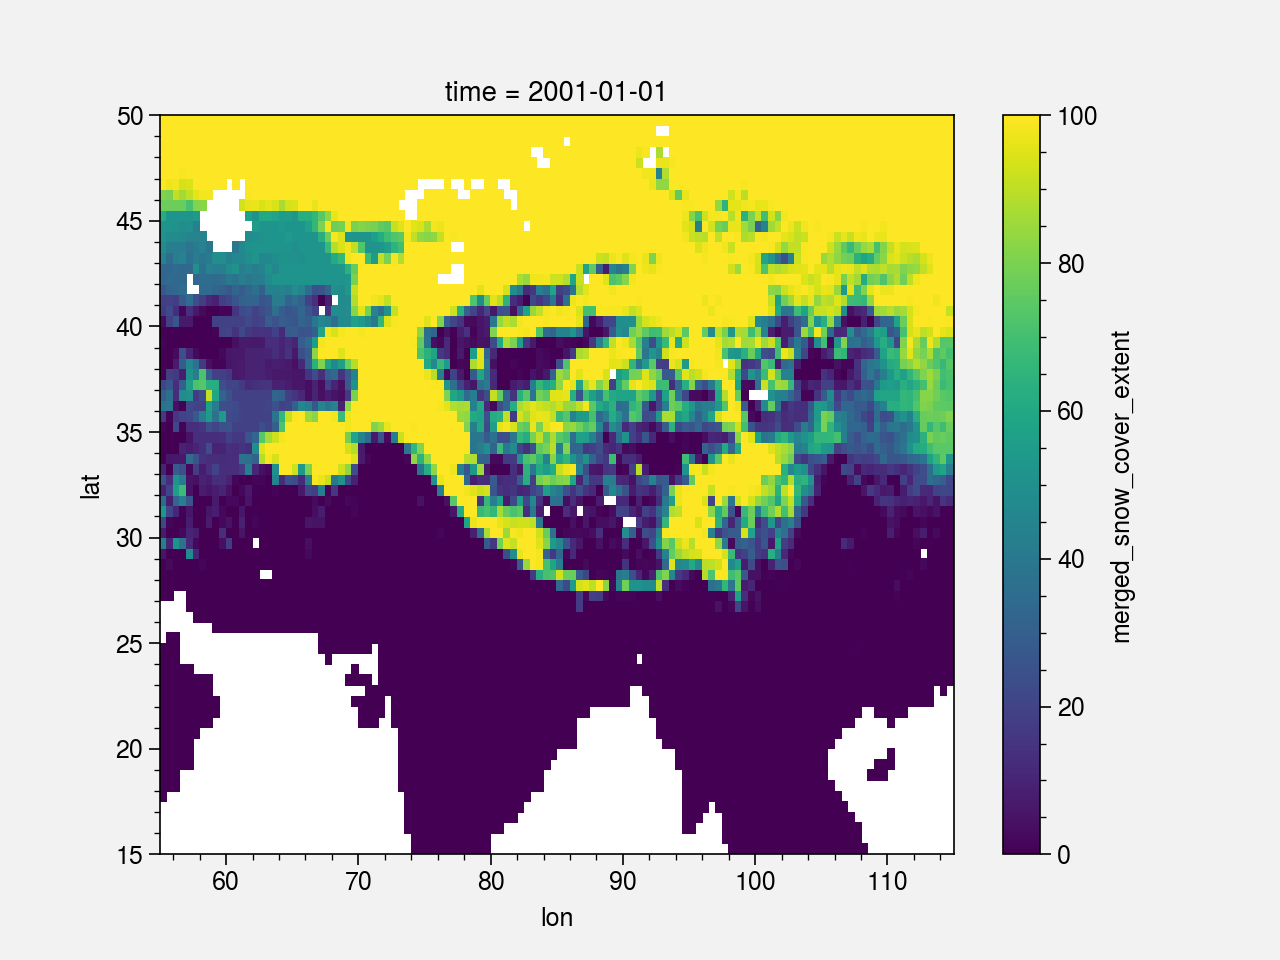

In [22]:
measures[0].plot()

## ESA snow CCI AVHRR (linear interpolation 10 days maxgap)
https://github.com/mickaellalande/PhD/blob/master/local/ESA_CCI_snow/snowCCI_preprocess_AVHRR_gricad_v1.ipynb

In [25]:
ds = xr.open_mfdataset('/data/mlalande/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly_0.5deg/*.nc', parallel=True).sel(time=period, lat=latlim, lon=lonlim)
# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, ds.time.size)

snow_cci_interp = ds['scfg_interp_0.5deg_icefilled']

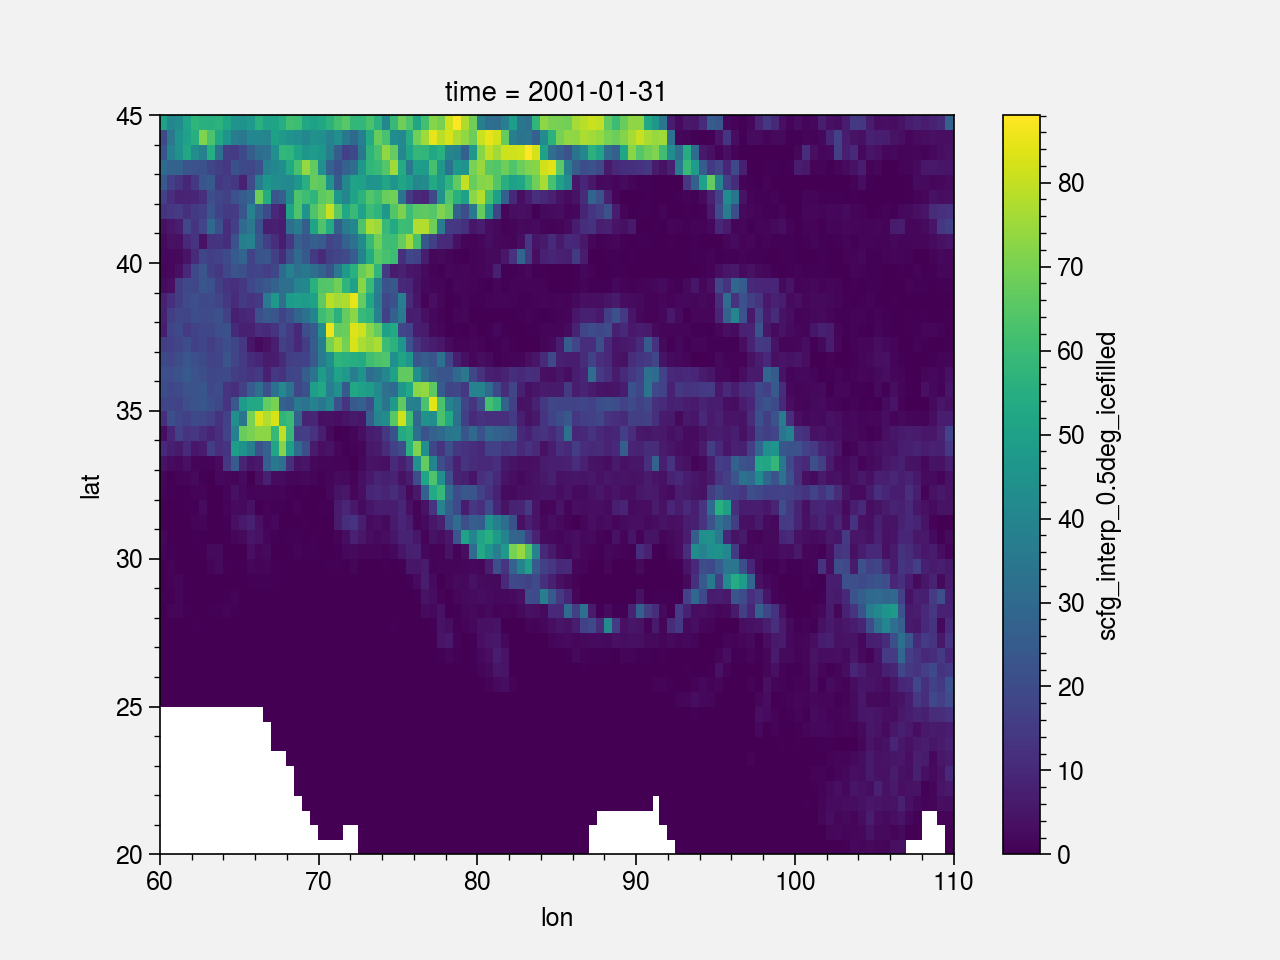

In [26]:
snow_cci_interp[0].plot()

## ESA snow CCI MODIS (linear interpolation 10 days maxgap)
https://github.com/mickaellalande/PhD/blob/master/local/ESA_CCI_snow/snowCCI_preprocess_MODIS_gricad_v1.ipynb

In [28]:
ds = xr.open_mfdataset('/data/mlalande/ESA_CCI_SNOW/preprocess/scfg/MODIS/v2.0/monthly_0.5deg/*.nc', parallel=True).sel(time=period, lat=latlim, lon=lonlim)
# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, ds.time.size)

snow_cci_MODIS_interp = ds['scfg_interp_0.5deg_icefilled']

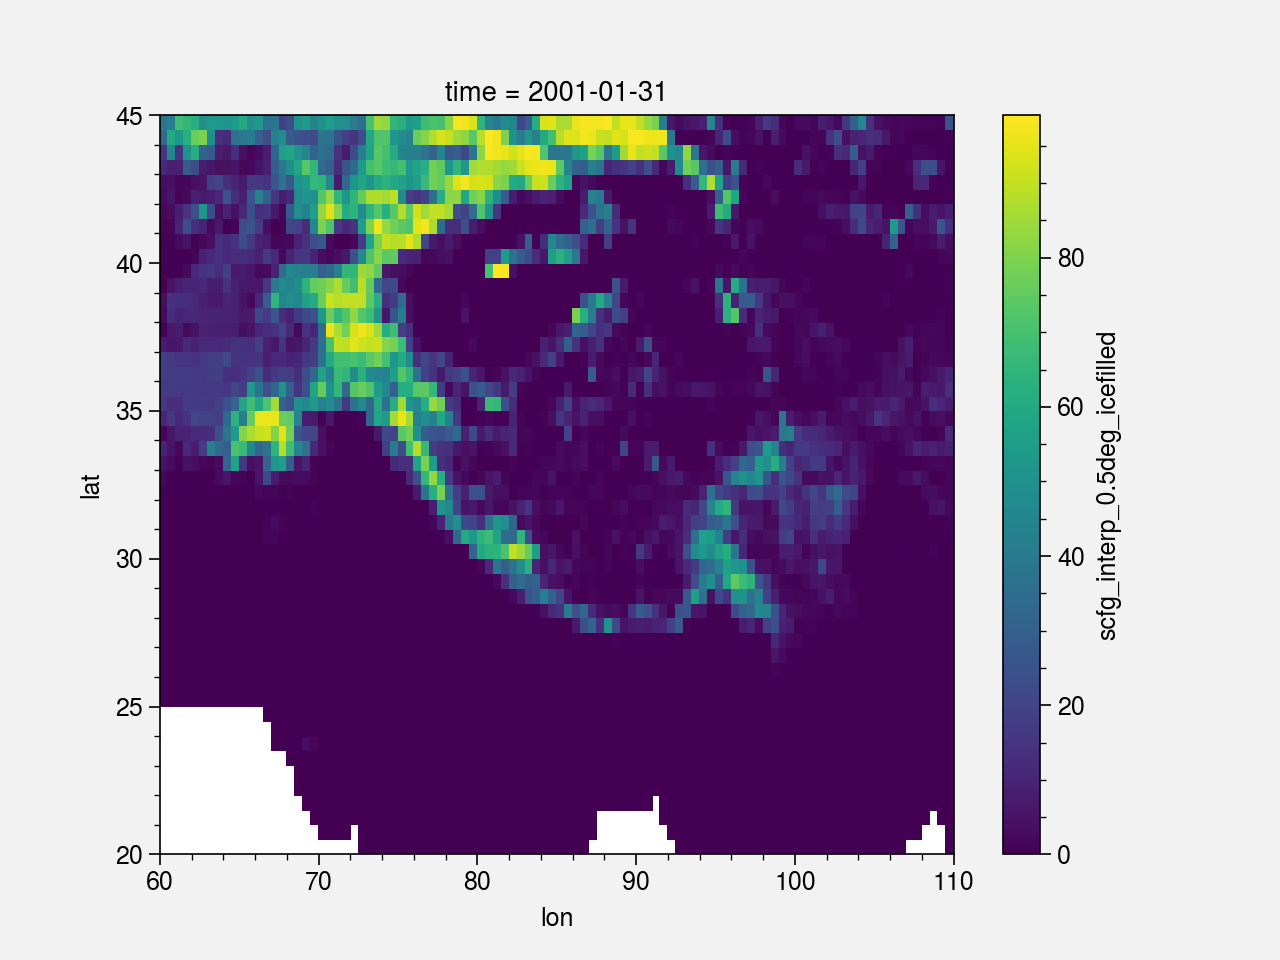

In [29]:
snow_cci_MODIS_interp[0].plot()

# Compare time series

In [30]:
snow_cci_interp_ts = snow_cci_interp.sel(lat=latlim, lon=lonlim).weighted(np.cos(np.deg2rad(snow_cci_interp.lat))).mean(('lat', 'lon')).load()
snow_cci_MODIS_interp_ts = snow_cci_MODIS_interp.sel(lat=latlim, lon=lonlim).weighted(np.cos(np.deg2rad(snow_cci_MODIS_interp.lat))).mean(('lat', 'lon')).load()
noaa_cdr_ts = noaa_cdr.sel(lat=latlim, lon=lonlim).weighted(np.cos(np.deg2rad(noaa_cdr.lat))).mean(('lat', 'lon')).load()
noaa_cdr_hr_ts = noaa_cdr_hr.sel(lat=latlim, lon=lonlim).weighted(np.cos(np.deg2rad(noaa_cdr_hr.lat))).mean(('lat', 'lon')).load()
measures_ts = measures.sel(lat=latlim, lon=lonlim).weighted(np.cos(np.deg2rad(measures.lat))).mean(('lat', 'lon')).load()

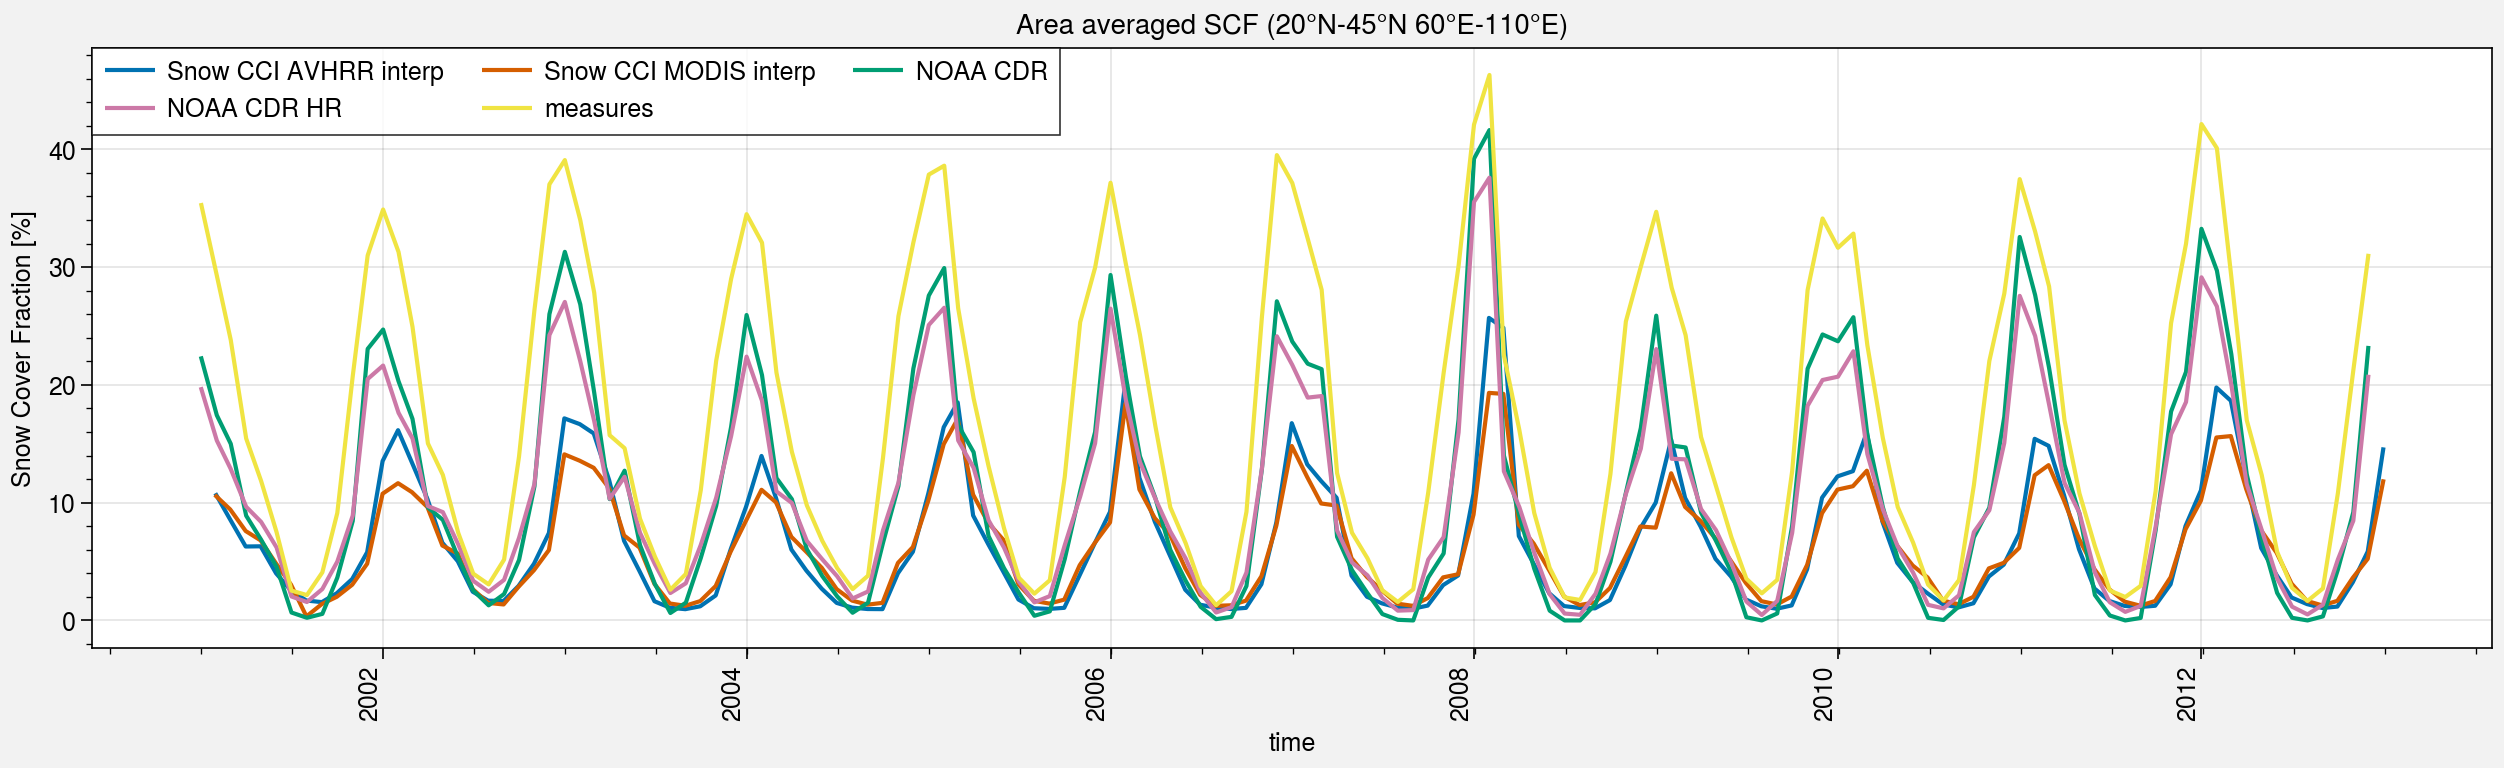

In [32]:
fig, axs = plot.subplots(aspect=4, axwidth=12)

snow_cci_interp_ts.plot(ax= axs[0], label='Snow CCI AVHRR interp')
snow_cci_MODIS_interp_ts.plot(ax= axs[0], label='Snow CCI MODIS interp')
noaa_cdr_ts.plot(ax= axs[0], label='NOAA CDR')
noaa_cdr_hr_ts.plot(ax= axs[0], label='NOAA CDR HR')
measures_ts.plot(ax= axs[0], label='measures')

axs.legend()

axs.format(
    ylabel='Snow Cover Fraction [%]',
    title='Area averaged SCF (20°N-45°N 60°E-110°E)'
)

fig.save('img/compare_snc_products_50km_ts.jpg')

In average MODIS has less snow than AVHRR over all area, but MODIS show more snow on mountainoues areas

# Plot

In [33]:
%%time
noaa_cdr.load()
noaa_cdr_hr.load()
measures.load()
snow_cci_interp.load()
snow_cci_MODIS_interp.load()

CPU times: user 820 ms, sys: 210 ms, total: 1.03 s
Wall time: 1.41 s


<xarray.DataArray 'scfg_interp_0.5deg_icefilled' (time: 144, lat: 50, lon: 100)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan, 0.00000000e+00],
        [           nan,            nan,            nan, ...,
                    nan,            nan, 0.00000000e+00],
        [           nan,            nan,            nan, ...,
                    nan, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.54584929e+01, 4.59659279e+01, 1.53607375e+01, ...,
         1.11620430e+00, 0.00000000e+00, 0.00000000e+00],
        [3.31442653e+01, 6.02511948e+01, 5.24976890e+01, ...,
         3.10903226e-02, 1.53388715e-01, 5.16316321e-01],
        [3.82907479e+01, 4.17478483e+01, 6.82862709e+01, ...,
         1.00470420e+00, 6.27074870e-01, 2.63484674e+01]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan, 0.00000000e+00],
        [           nan,            nan,            nan, ...,
                    nan,            nan, 0.00000000e+00],
        [           nan,            nan,            nan, ...,
                    nan, 0.00000000e+00, 0.00000000e+00],
...
        [0.00000000e+00, 0.00000000e+00, 2.55391848e-02, ...,
         2.94345673e+01, 2.61758120e+01, 2.12996710e+01],
        [4.16688968e-02, 7.00103681e-02, 9.00526462e-03, ...,
         8.56673330e-01, 1.09576017e+01, 1.44879881e+01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.56250341e+00, 8.86223636e-01, 1.26915760e+00]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan, 0.00000000e+00],
        [           nan,            nan,            nan, ...,
                    nan,            nan, 0.00000000e+00],
        [           nan,            nan,            nan, ...,
                    nan, 0.00000000e+00, 0.00000000e+00],
        ...,
        [2.74564704e+01, 2.05440906e+01, 1.45877375e+01, ...,
         1.41099475e+01, 2.34157671e+01, 5.33738975e+01],
        [2.10115154e+01, 4.34862670e+01, 2.94229699e+01, ...,
         5.60254320e+00, 1.01704403e+01, 1.31820047e+01],
        [2.83631725e+00, 2.83102772e+00, 9.81015118e+00, ...,
         1.26103495e+00, 8.40361399e-01, 1.18099700e+00]]])
Coordinates:
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 108.2 108.8 109.2 109.8
  * lat      (lat) float64 20.25 20.75 21.25 21.75 ... 43.25 43.75 44.25 44.75
  * time     (time) datetime64[ns] 2001-01-31 2001-02-28 ... 2012-12-31

NOAA CDR
Annual
DJFMA
JJAS
NOAA CDR HR
Annual
DJFMA
JJAS
MEaSUREs
Annual
DJFMA
JJAS
Snow CCI AVHRR interp
Annual
DJFMA
JJAS
Snow CCI MODIS interp
Annual
DJFMA
JJAS
CPU times: user 10.3 s, sys: 2.78 s, total: 13.1 s
Wall time: 9.63 s


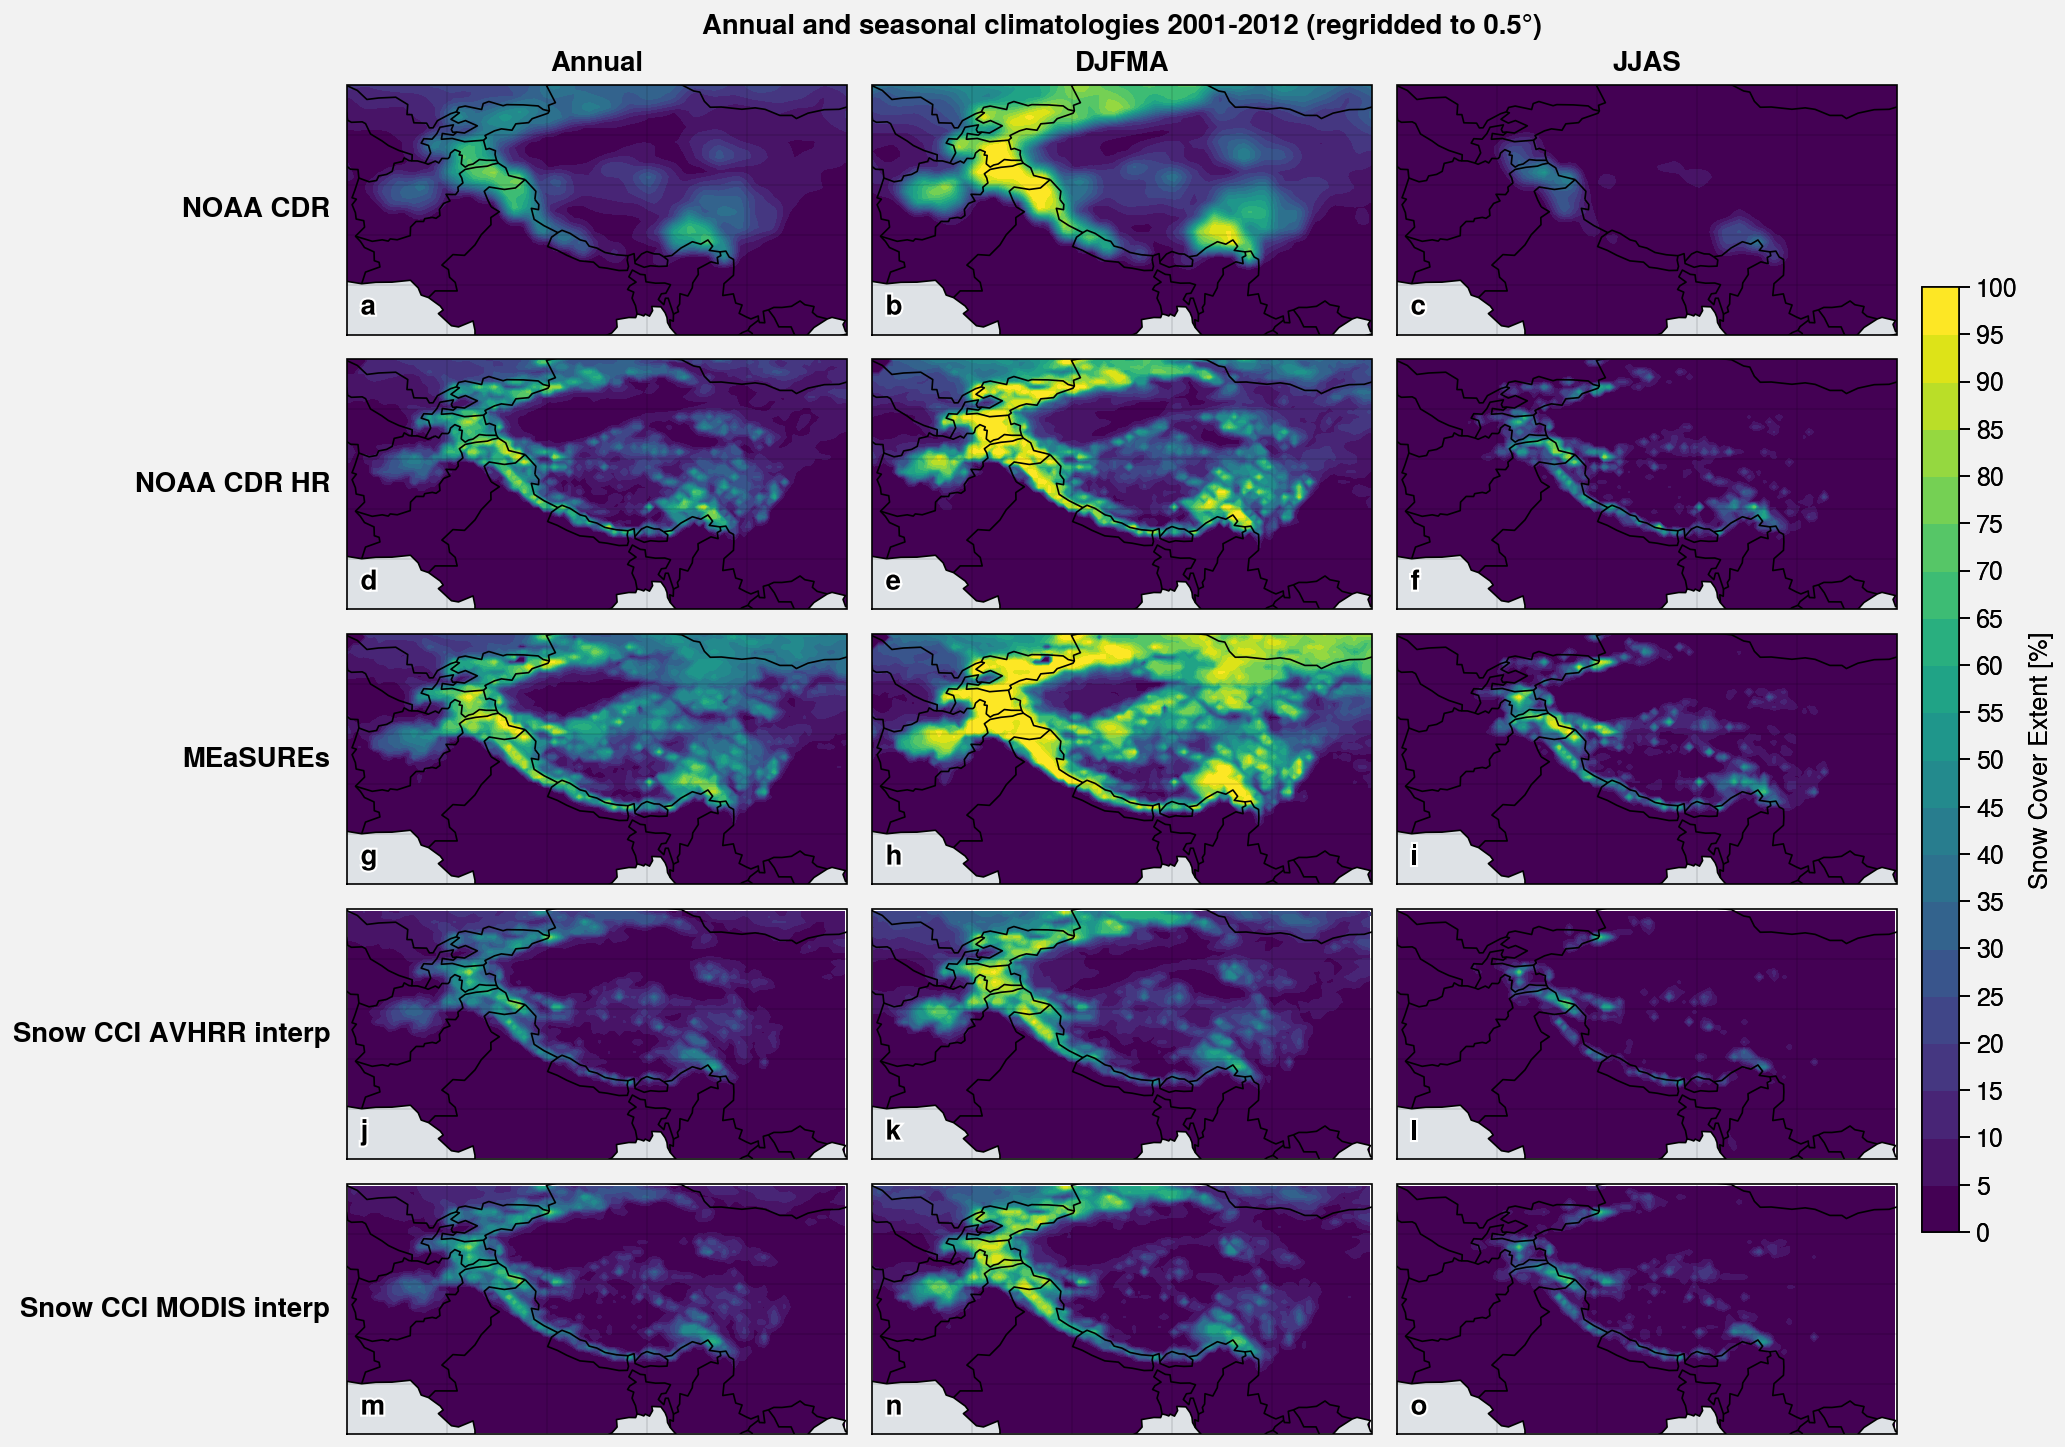

In [34]:
%%time
obs_list = [noaa_cdr, noaa_cdr_hr, measures, snow_cci_interp, snow_cci_MODIS_interp]
obs_list_names = ['NOAA CDR', 'NOAA CDR HR', 'MEaSUREs', 'Snow CCI AVHRR interp', 'Snow CCI MODIS interp']

fig, axs = plot.subplots(nrows=len(obs_list), ncols=len(seasons), proj='cyl')

k = 0
for i, obs in enumerate(obs_list):
    print(obs_list_names[i])
    for i_season, season in enumerate(seasons):
        print(season)
        m = axs[k].contourf(u.clim(obs, season=seasons[i_season], skipna=True), cmap='viridis', levels=plot.arange(0,100,5))
        k += 1

fig.colorbar(m, label='Snow Cover Extent [%]', length=0.7)

axs.format(
    # Grids, labels and limits
    labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    abc=True, abcloc='ll',
    rowlabels=obs_list_names, collabels=seasons,
    suptitle='Annual and seasonal climatologies '+period.start+'-'+period.stop+' (regridded to 0.5°)'
)

fig.save('img/snc_product_clim_50km.jpg')

### Trends

In [38]:
def corr(x, y, dim):
    return xr.apply_ufunc(
        stats.linregress, x, y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True
    )

def theilslopes(y, x, dim):
    return xr.apply_ufunc(
        stats.theilslopes, y, x,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], [], [], []],
        vectorize=True
    )

In [39]:
%%time
obs_list = [noaa_cdr, noaa_cdr_hr, measures, snow_cci_interp, snow_cci_MODIS_interp]
obs_list_names = ['NOAA CDR', 'NOAA CDR HR', 'MEaSUREs', 'Snow CCI AVHRR interp', 'Snow CCI MODIS interp']

ym_obs = []
for i, obs in enumerate(obs_list):
    print(obs_list_names[i])
    ym_temp = []
    for season in seasons:
        print(season)
        # Make annual mean
        ym = u.year_mean(obs.load(), calendar='standard', season=season)

        # Compute trends
        for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym.year, ym, 'year')):
            ym[arr_name] = arr
            
        # Compute theilslopes (https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.mstats.theilslopes.html)
        for arr_name, arr in zip(['medslope', 'medintercept', 'lo_slope', 'up_slope'], theilslopes(ym, ym.year, 'year')):
            ym[arr_name] = arr

        ym_temp.append(ym)

    ym_obs.append(xr.concat(ym_temp, pd.Index(seasons, name='season')))

NOAA CDR
Annual
DJFMA


/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
NOAA CDR HR
Annual
DJFMA


/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
MEaSUREs
Annual
DJFMA


/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
Snow CCI AVHRR interp
Annual
DJFMA


/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
Snow CCI MODIS interp
Annual
DJFMA


/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
CPU times: user 2min 58s, sys: 35.3 s, total: 3min 33s
Wall time: 2min 49s


NOAA CDR
Annual
DJFMA
JJAS
NOAA CDR HR
Annual
DJFMA
JJAS
MEaSUREs
Annual
DJFMA
JJAS
Snow CCI AVHRR interp
Annual
DJFMA
JJAS
Snow CCI MODIS interp
Annual
DJFMA
JJAS
CPU times: user 1min 54s, sys: 15.1 s, total: 2min 9s
Wall time: 1min 51s


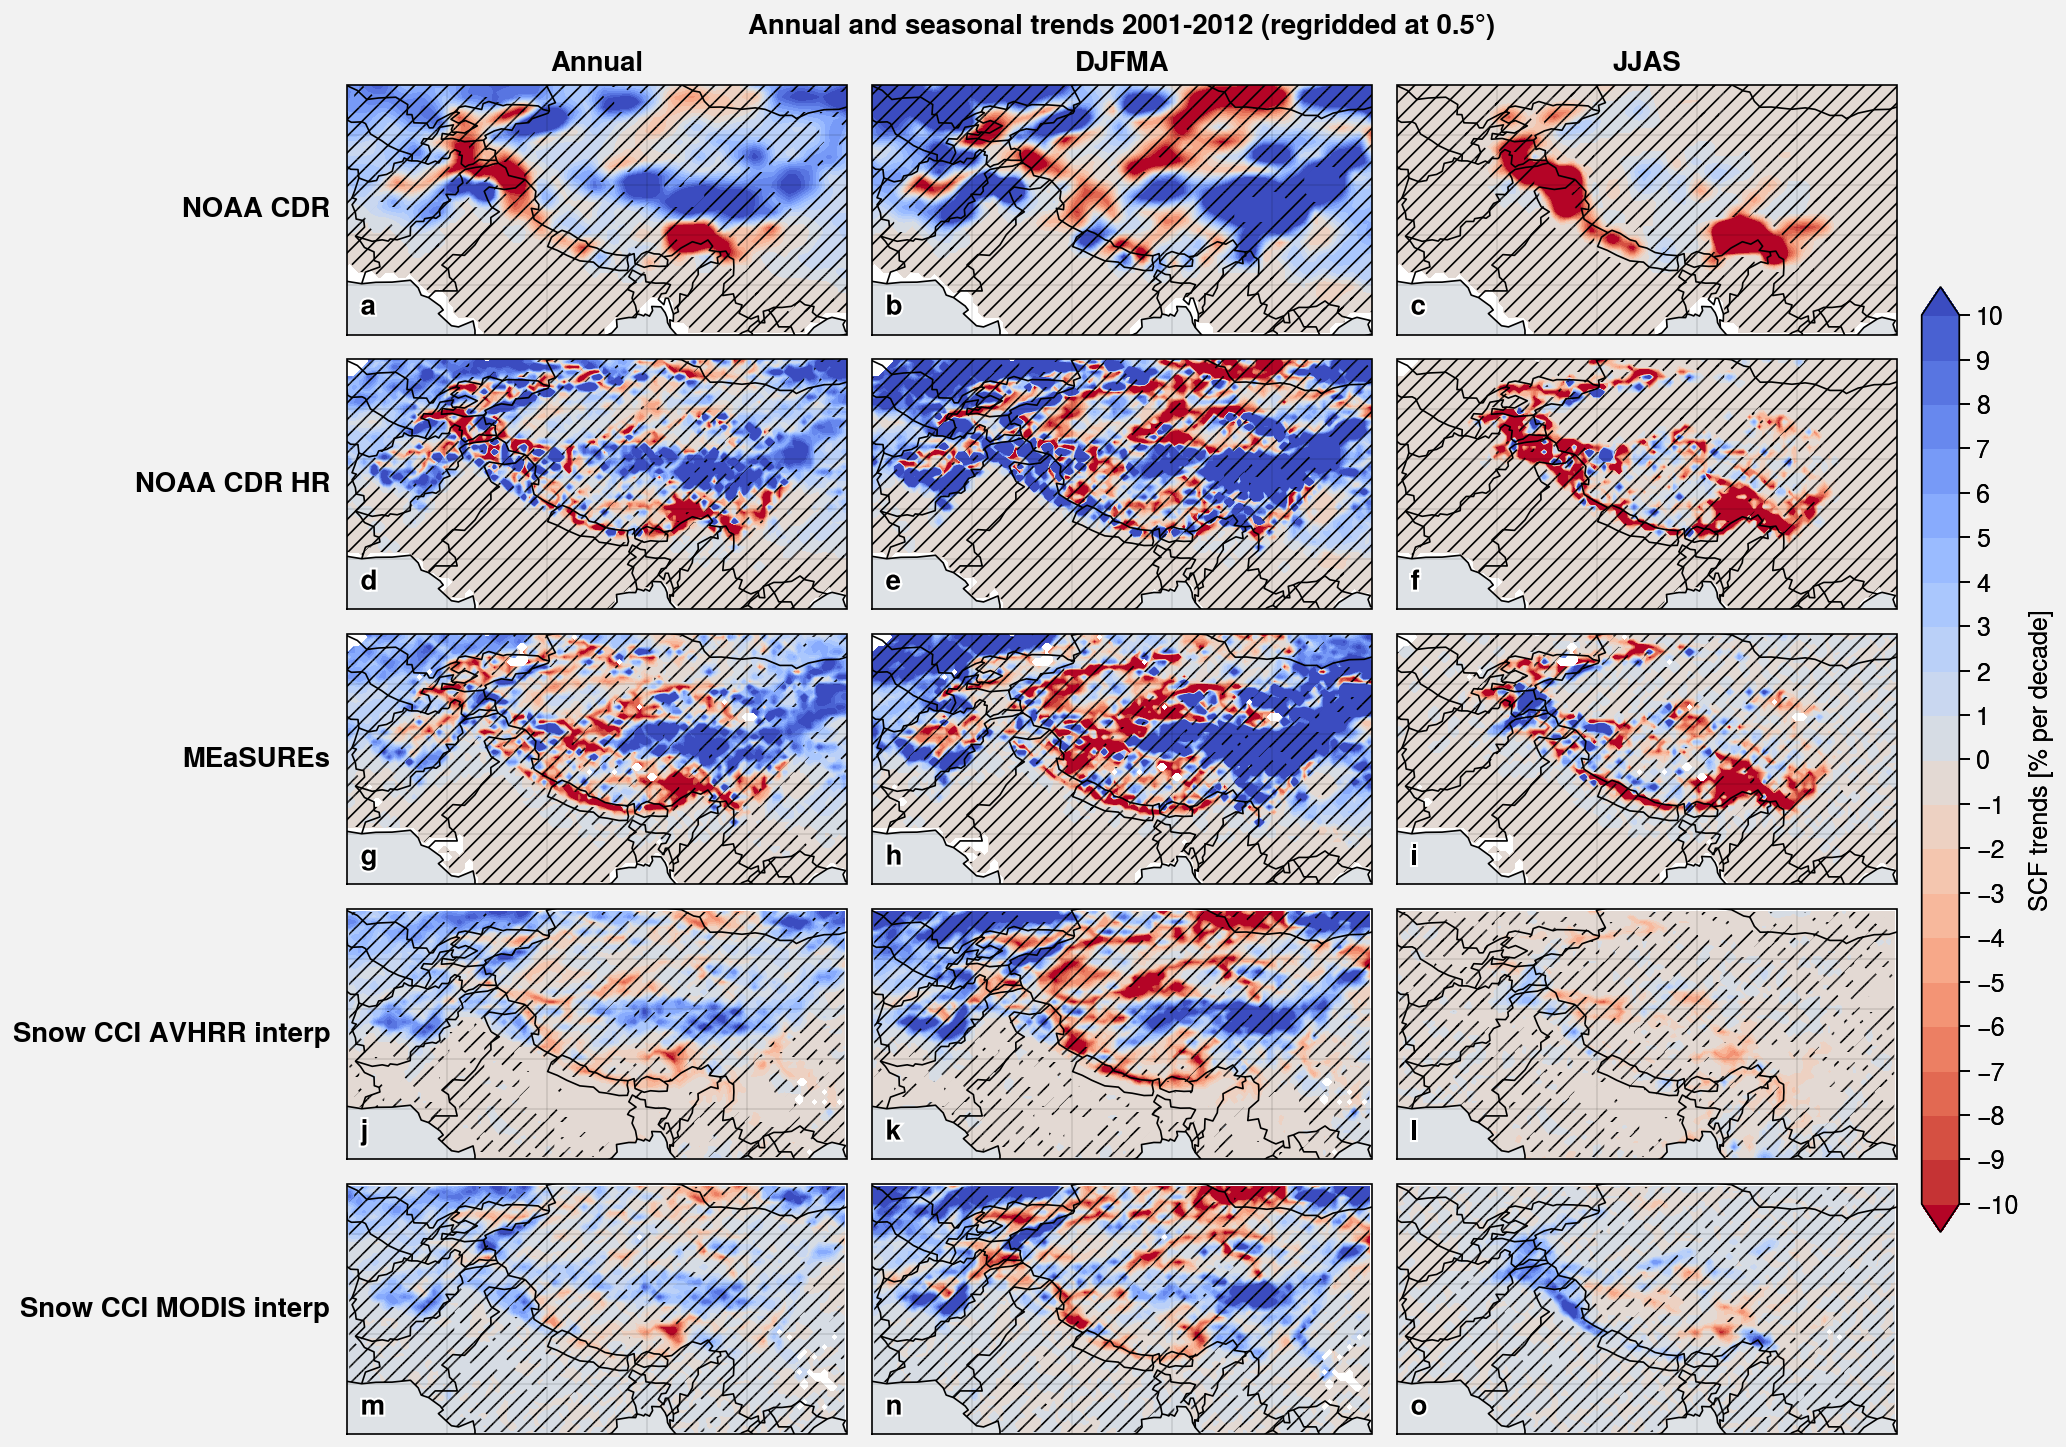

In [40]:
%%time
obs_list = [noaa_cdr, noaa_cdr_hr, measures, snow_cci_interp, snow_cci_MODIS_interp]
obs_list_names = ['NOAA CDR', 'NOAA CDR HR', 'MEaSUREs', 'Snow CCI AVHRR interp', 'Snow CCI MODIS interp']

fig, axs = plot.subplots(nrows=len(obs_list), ncols=len(seasons), proj='cyl')

k = 0
for i, obs in enumerate(ym_obs):
    print(obs_list_names[i])
    for i_season, season in enumerate(seasons):
        print(season)
        m = axs[k].contourf(obs.sel(season=season).slope*10, cmap='CoolWarm_r', levels=plot.arange(-10,10,1), extend='both')
        pvalue = obs.sel(season=season).pvalue
        axs[k].contourf(pvalue.where(pvalue>0.05), hatches=['////'], alpha=0)
        k += 1

fig.colorbar(m, label='SCF trends [% per decade]', length=0.7)        

axs.format(
    # Grids, labels and limits
    labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    abc=True, abcloc='ll',
    rowlabels=obs_list_names, collabels=seasons,
    suptitle='Annual and seasonal trends '+period.start+'-'+period.stop+' (regridded at 0.5°)'
)

fig.save('img/snc_product_trends_50km.jpg')

NOAA CDR
Annual
DJFMA
JJAS
NOAA CDR HR
Annual
DJFMA
JJAS
MEaSUREs
Annual
DJFMA
JJAS
Snow CCI AVHRR interp
Annual
DJFMA
JJAS
Snow CCI MODIS interp
Annual
DJFMA
JJAS
CPU times: user 19.8 s, sys: 6.1 s, total: 25.9 s
Wall time: 18.4 s


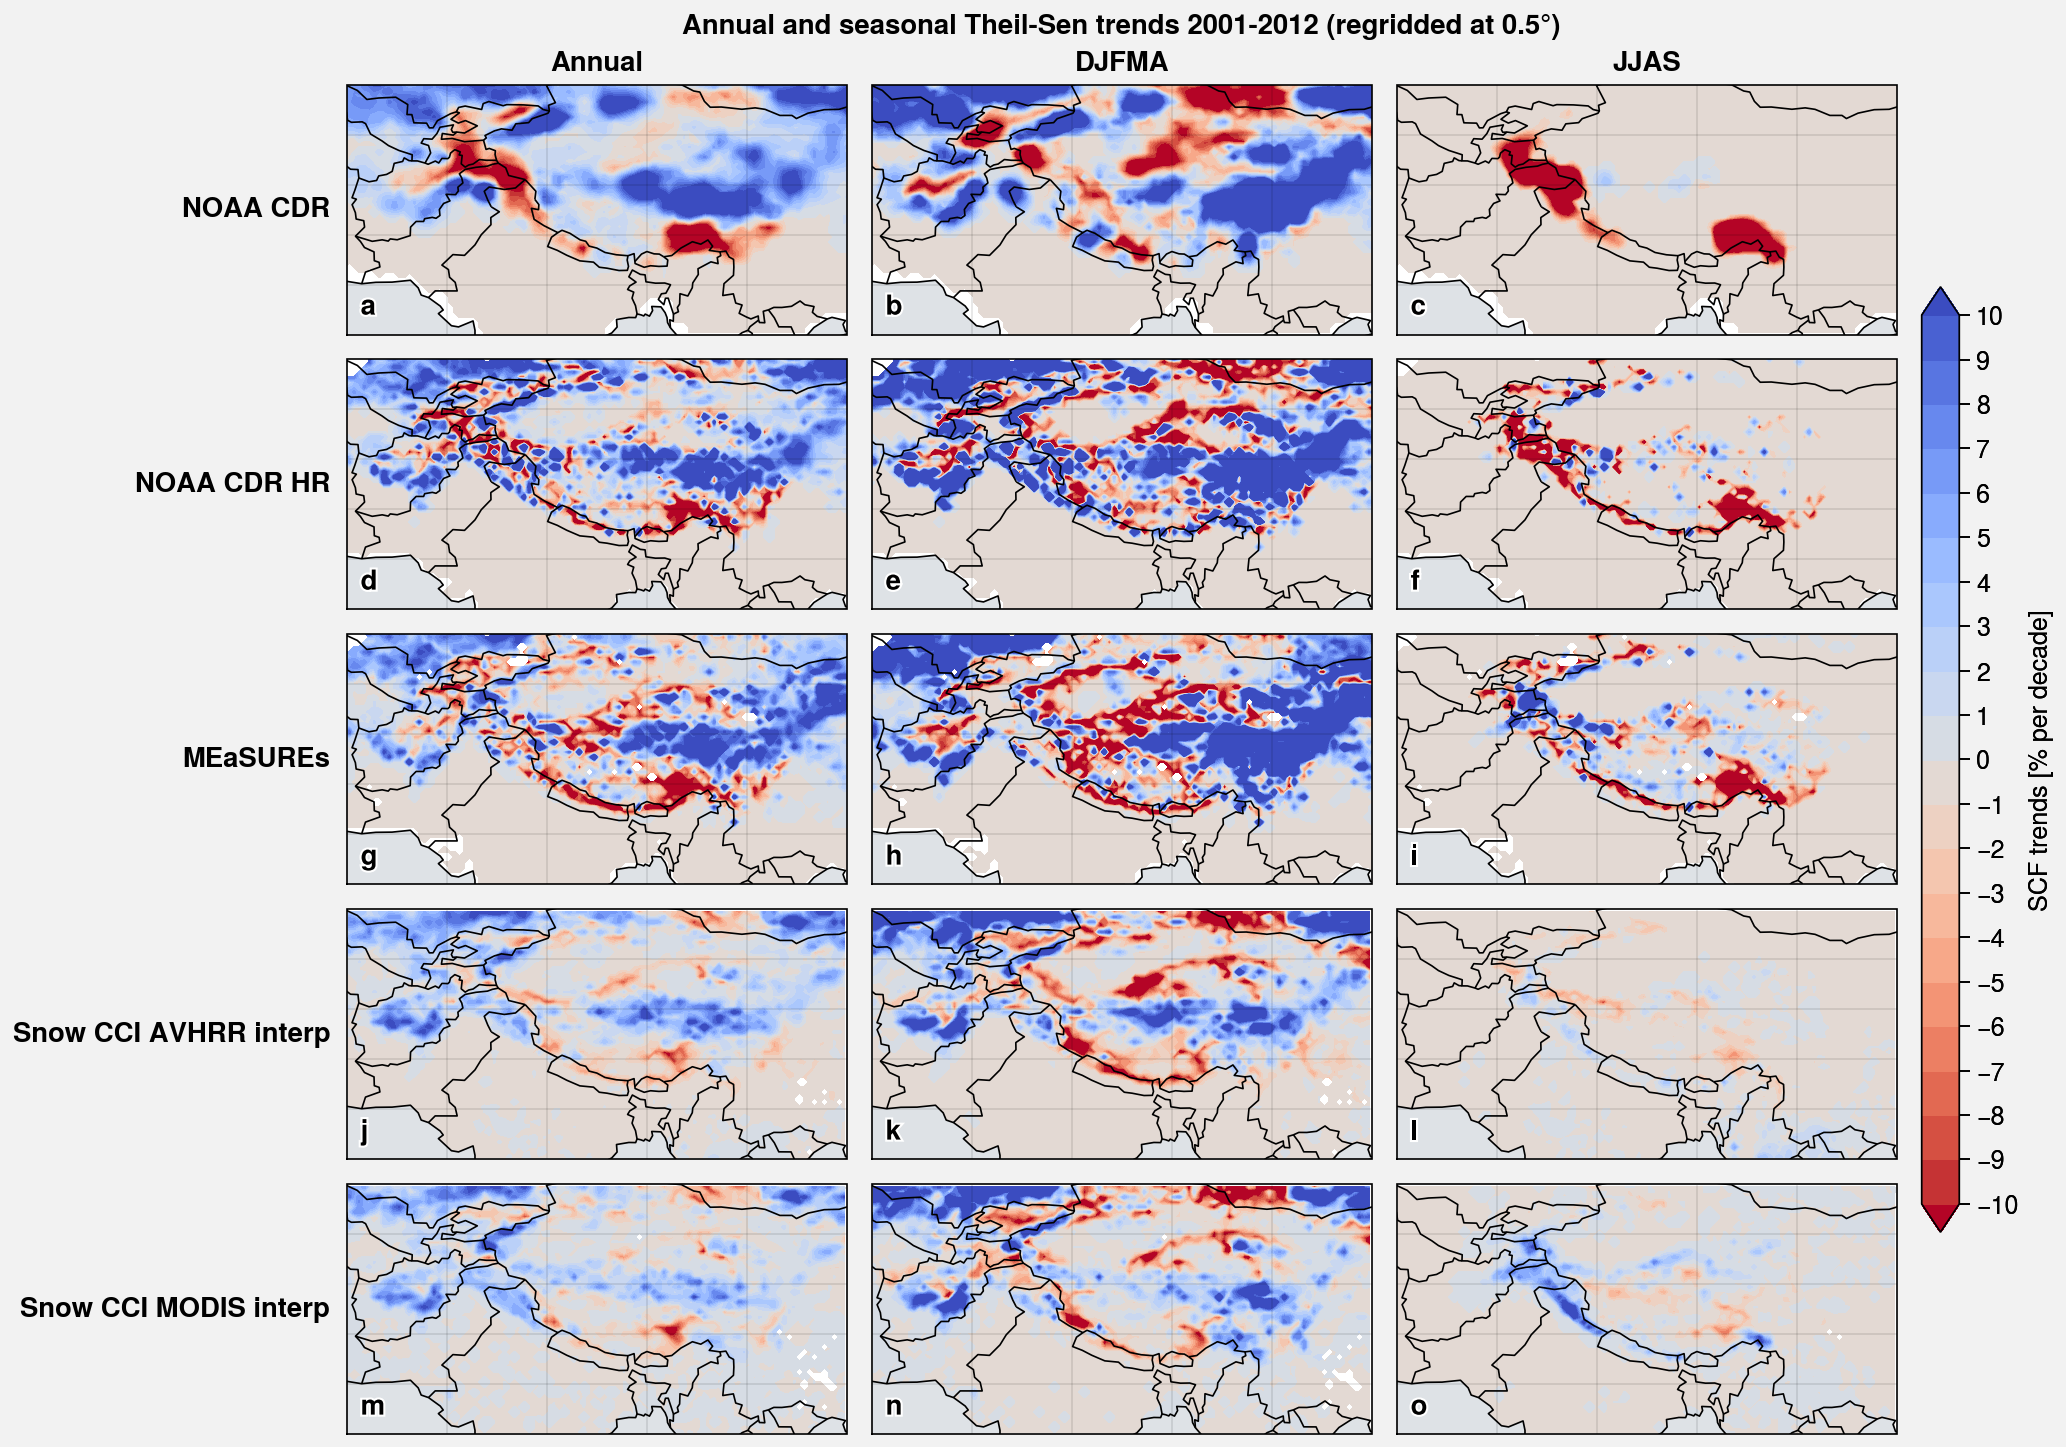

In [41]:
%%time
obs_list = [noaa_cdr, noaa_cdr_hr, measures, snow_cci_interp, snow_cci_MODIS_interp]
obs_list_names = ['NOAA CDR', 'NOAA CDR HR', 'MEaSUREs', 'Snow CCI AVHRR interp', 'Snow CCI MODIS interp']

fig, axs = plot.subplots(nrows=len(obs_list), ncols=len(seasons), proj='cyl')

k = 0
for i, obs in enumerate(ym_obs):
    print(obs_list_names[i])
    for i_season, season in enumerate(seasons):
        print(season)
        m = axs[k].contourf(obs.sel(season=season).medslope*10, cmap='CoolWarm_r', levels=plot.arange(-10,10,1), extend='both')
        k += 1

fig.colorbar(m, label='SCF trends [% per decade]', length=0.7)        

axs.format(
    # Grids, labels and limits
    labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    abc=True, abcloc='ll',
    rowlabels=obs_list_names, collabels=seasons,
    suptitle='Annual and seasonal Theil-Sen trends '+period.start+'-'+period.stop+' (regridded at 0.5°)'
)

fig.save('img/snc_product_theilsen_trends_50km.jpg')